In [1]:
import time
import numpy as np
import pandas as pd

import galsim #install with conda install -c conda_forge galsim

import matplotlib.pyplot as plt
from matplotlib import pyplot
import matplotlib.cm as cm
import matplotlib.colors as norm
from matplotlib.gridspec import SubplotSpec
import seaborn as sns

from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn import svm
from sklearn.svm import SVR

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import cross_validate, KFold, StratifiedKFold
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score
from sklearn.inspection import permutation_importance
from sklearn.pipeline import make_pipeline, Pipeline #This allows one to build different steps together
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.compose import TransformedTargetRegressor

from tqdm import tqdm 

import target_predicting_RF_function_and_feature_ranking_TNGSIM_0D as functions
import RF_target_predicting_and_learning_curves_functions_TNGSIM_0D as tp_lc_functions

In [2]:
# Using the 0D TNG100 SIM data at z=0, disk galaxies only

df_0D = pd.read_csv('TNG-SIM_images/v24a_Disks_SVR_0DwMvir/v24a_TNG-SIM_Disks_0D_wMvir_Dataset.csv')
df_raw = pd.read_csv('TNG-SIM_images/v24a_Disks_SVR_0DwMvir/v24a_TNG-SIM_Disks_Dataset_Raw.csv')
print("df_0D.shape", df_0D.shape)
print("df_raw.shape", df_raw.shape)

df_0D.shape (3215, 17)
df_raw.shape (3215, 19)


### <font color='purple'> <a id =10> </a> <br> Take Log10 of all features and target, both 0D & raw

### <font color='purple'> <a id =10> </a> <br> Disks Raw Dataset Eqn Search
    
Run the following file on terminal:
    SR_TNG-SIM_disks_eqn_search_raw.py

### <font color='purple'> <a id =10> </a> <br> Disks Raw 1K iterations

In [3]:
v1_SR_eqns_n_iter1K = pd.read_csv('/Users/festabu/Desktop/ML_galaxy_size_project/Codes/TNG-SIM_images/v28_SR_eqn_search_disks/SR_v1_disks_eqn_search/run1_hall_of_fame_2024-03-26_153512.794.csv', sep='|')

In [4]:
# for i in range(SR_eqns_n_iter1K.shape[0]):
for i in range(17):
    
    print (v1_SR_eqns_n_iter1K.loc[i, 'Equation'])

2.8749168
(SubhaloSFRinRad - -2.0077646)
(pow(SubhaloMH2, 0.30211973) / 149.12662)
(pow(SubhaloMH2 / SubhaloStarMetallicity, 0.451902) * 4.3108543e-5)
(pow(square(SubhaloMH2 / SubhaloStarMetallicity), 0.22616078) * 4.265639e-5)
((pow(SubhaloMH2 / SubhaloStarMetallicity, 0.3242399) * 0.0014791337) - 1.3420265)
(square(pow(SubhaloMH2 / SubhaloStarMetallicity, 0.22574143) - SubhaloSFRinRad) * 4.4053795e-5)
((pow(SubhaloMH2 / SubhaloStarMetallicity, 0.17430264) * (0.14299151 - SubhaloStarMetallicity)) - 6.461586)
square((pow(SubhaloMH2 / SubhaloStarMetallicity, 0.12422826) * (0.19467312 - SubhaloStarMetallicity)) - 2.1683495)
square((pow(SubhaloMstar, 0.09148883) - 3.6894493) + (((SubhaloStarMetallicity * 2.7199903) / 0.14257741) / -0.13593534))
(square((pow(SubhaloMstar, 0.094090655) - 4.094888) + (((SubhaloStarMetallicity * 2.6941903) / 0.1691653) / -0.10373602)) - -0.5363104)
(square((pow(SubhaloMstar, 0.09489149) - 4.1202326) + (((SubhaloStarMetallicity * 3.1499376) / (SubhaloStarMetal

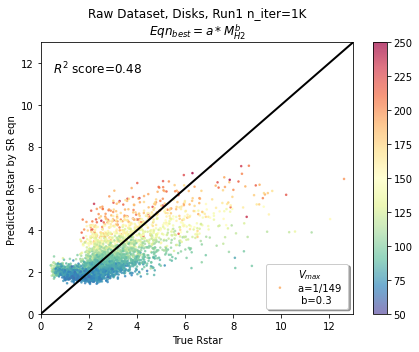

In [24]:
# 'best' eqn is the 2nd eqn: 0.00670571089185821*Abs(SubhaloMH2)**0.30211973

sr_disks_v1_eqn1 = (1/149)*(df_raw.SubhaloMH2**0.3)

r2_score_disks_1=r2_score(df_raw.SubhaloRstar, sr_disks_v1_eqn1)

fig_complete, ax = plt.subplots(figsize=(7, 5))

fig_SR = ax.scatter(df_raw.SubhaloRstar, sr_disks_v1_eqn1,
            c = df_raw.SubhaloVmax, 
            cmap='Spectral_r',
            s=10, marker='.', alpha=0.7,label= r'$V_{max}$'+'\n'+'a=1/149 \n b=0.3', vmin=50, vmax=250)
ax.text(0.5, 11.5, r'$R^{2}$ score=' + '{:.2f}'.format(r2_score_disks_1), size=12)
ax.axis([0.0,13, 0.0,13])
ax.plot([0.0, 15], [0.0, 15], color = 'black', linewidth = 2)
ax.set_title(r'Raw Dataset, Disks, Run1 n_iter=1K' + '\n'+ r'$Eqn_{best} = a* M_{H2}^{b}$')
ax.set_xlabel('True Rstar')
ax.legend(loc = 'lower right', shadow=True)
ax.set_ylabel('Predicted Rstar by SR eqn ')
fig_complete.colorbar(fig_SR, ax=ax)
# plt.savefig('TNG-SIM_images/v28_SR_eqn_search_disks/SR_v1_disks_eqn_search/v1_disks_SR_besteqn_raw.jpeg', dpi=500)
plt.show()

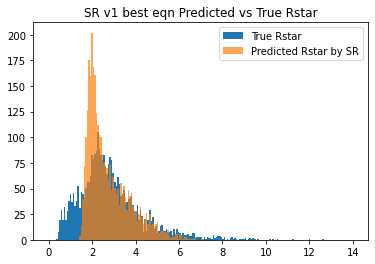

In [17]:
plt.hist(df_raw.SubhaloRstar, bins=200, label='True Rstar'
        , range=(0.0, 14))
plt.hist(sr_disks_v1_eqn1, bins=200, alpha=0.7, label='Predicted Rstar by SR'
        , range=(0.0, 14))
plt.legend(loc='upper right')
plt.title(r'SR v1 best eqn Predicted vs True Rstar')
# plt.savefig('TNG-SIM_images/v28_SR_eqn_search_disks/SR_v1_disks_eqn_search/v1_run1eqnbes_Histogram_SR_pred_true_TNG-SIM_Raw_disks.jpeg', dpi=500)
plt.show()

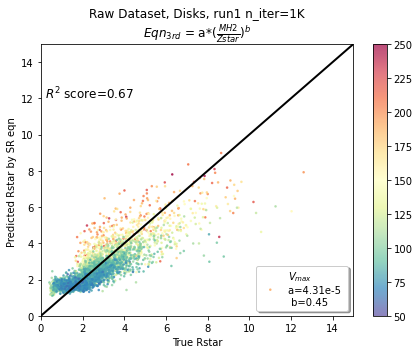

In [23]:
# 3rd eqn:(pow(SubhaloMH2 / SubhaloStarMetallicity, 0.451902) * 4.3108543e-5)


sr_disks_v1_eqn1 = 4.31e-5 * (df_raw.SubhaloMH2/df_raw.SubhaloStarMetallicity)**0.45

r2_score_disks_1=r2_score(df_raw.SubhaloRstar, sr_disks_v1_eqn1)

fig_complete, ax = plt.subplots(figsize=(7, 5))

fig_SR = ax.scatter(df_raw.SubhaloRstar, sr_disks_v1_eqn1,
            c = df_raw.SubhaloVmax, 
            cmap='Spectral_r',
            s=10, marker='.', alpha=0.7,label= r'$V_{max}$'+'\n'+'a=4.31e-5 \n b=0.45', vmin=50, vmax=250)
ax.text(0.2, 12, r'$R^{2}$ score=' + '{:.2f}'.format(r2_score_disks_1), size=12)
ax.axis([0.0,15, 0.0,15])
ax.plot([0.0, 15], [0.0, 15], color = 'black', linewidth = 2)
ax.set_title(r'Raw Dataset, Disks, run1 n_iter=1K' + '\n'+ r'$Eqn_{3rd}$ = a*$(\frac{MH2}{Zstar})^{b}$')
ax.set_xlabel('True Rstar')
ax.legend(loc = 'lower right', shadow=True)
ax.set_ylabel('Predicted Rstar by SR eqn ')
fig_complete.colorbar(fig_SR, ax=ax)
# plt.savefig('TNG-SIM_images/v28_SR_eqn_search_disks/SR_v1_disks_eqn_search/v1_disks_SR_3rdeqn_raw.jpeg', dpi=500)
plt.show()

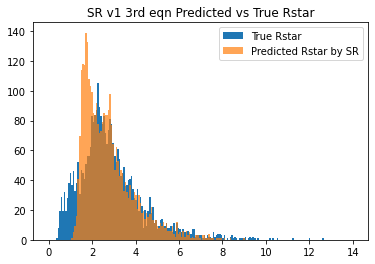

In [12]:
plt.hist(df_raw.SubhaloRstar, bins=200, label='True Rstar'
        , range=(0.0, 14))
plt.hist(sr_disks_v1_eqn1, bins=200, alpha=0.7, label='Predicted Rstar by SR'
        , range=(0.0, 14))
plt.legend(loc='upper right')
plt.title(r'SR v1 3rd eqn Predicted vs True Rstar')
# plt.savefig('TNG-SIM_images/v28_SR_eqn_search_disks/SR_v1_disks_eqn_search/v1_run1eqn3rd_Histogram_SR_pred_true_TNG-SIM_Raw_disks.jpeg', dpi=500)
plt.show()

#### <font color='purple'> <a id =10> </a> <br> Disks Raw 5K iterations

In [14]:
v1_SR_eqns_n_iter5K = pd.read_csv('/Users/festabu/Desktop/ML_galaxy_size_project/Codes/TNG-SIM_images/v28_SR_eqn_search_disks/SR_v1_disks_eqn_search/run2_hall_of_fame_2024-03-26_155655.407.csv', sep='|')

In [16]:
# for i in range(SR_eqns_n_iter1K.shape[0]):
for i in range(20):
    
    print (v1_SR_eqns_n_iter5K.loc[i, 'Equation'])

2.874916
(SubhaloSFRinRad + 2.0079553)
(pow(SubhaloMH2, 0.30205426) / 148.91725)
(pow(SubhaloMstar, 0.48975965) * (9.594897e-7 / SubhaloStarMetallicity))
(pow(SubhaloMstar / square(SubhaloStarMetallicity), 0.5925918) * 4.4427676e-8)
(pow(SubhaloMstar / SubhaloStarMetallicity, 0.69641846) * (4.766733e-10 / SubhaloStarMetallicity))
((pow(SubhaloMstar / SubhaloStarMetallicity, 0.6858654) * (6.370096e-10 / SubhaloStarMetallicity)) - 0.03512333)
((pow(SubhaloMstar / square(SubhaloStarMetallicity), 0.7009815) * 2.1470659e-9) / pow(SubhaloMstar, SubhaloStarMetallicity))
((pow(SubhaloMstar / square(SubhaloStarMetallicity), 0.6783701) * 5.186724e-7) * square(SubhaloStarMetallicity + -0.09195692))
(((pow(SubhaloMstar / square(SubhaloStarMetallicity), 0.6388998) * 1.6215612e-8) / pow(SubhaloMstar, SubhaloStarMetallicity)) - 0.40819296)
(((pow(SubhaloMstar / square(SubhaloStarMetallicity), 0.6636297) * 7.266605e-9) / pow(SubhaloMstar, SubhaloStarMetallicity)) - pow(SubhaloGasMetallicity, 0.3210089

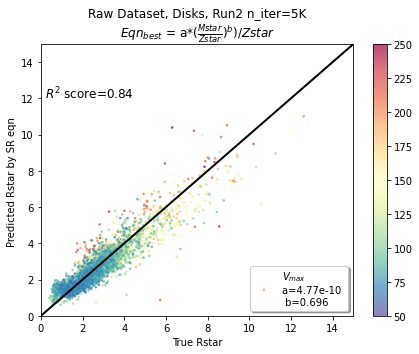

In [33]:
# 'best' eqn is 5th eqn with 5K runs: 4.766733e-10*Abs(SubhaloMstar/SubhaloStarMetallicity)**0.69641846/SubhaloStarMetallicity

a=4.77e-10
b=0.696
# Note: This eqn is very sensitive to the power; rounding up b=0.7 decreases the R2 score by 0.05!

sr_disks_v2_eqn1 = a*((df_raw.SubhaloMstar/df_raw.SubhaloStarMetallicity)**b)/df_raw.SubhaloStarMetallicity

r2_score_disks_1=r2_score(df_raw.SubhaloRstar, sr_disks_v2_eqn1)

fig_complete, ax = plt.subplots(figsize=(7, 5))

fig_SR = ax.scatter(df_raw.SubhaloRstar, sr_disks_v2_eqn1,
            c = df_raw.SubhaloVmax, 
            cmap='Spectral_r',
            s=10, marker='.', alpha=0.7,label= r'$V_{max}$'+'\n'+'a=4.77e-10 \n b=0.696', vmin=50, vmax=250)
ax.text(0.2, 12, r'$R^{2}$ score=' + '{:.2f}'.format(r2_score_disks_1), size=12)
ax.axis([0.0,15, 0.0,15])
ax.plot([0.0, 15], [0.0, 15], color = 'black', linewidth = 2)
ax.set_title(r'Raw Dataset, Disks, Run2 n_iter=5K' + '\n'+ r'$Eqn_{best}$ = a*$(\frac{Mstar}{Zstar})^{b})/Zstar$')
ax.set_xlabel('True Rstar')
ax.legend(loc = 'lower right', shadow=True)
ax.set_ylabel('Predicted Rstar by SR eqn ')
fig_complete.colorbar(fig_SR, ax=ax)
# plt.savefig('TNG-SIM_images/v28_SR_eqn_search_disks/SR_v1_disks_eqn_search/v1_run2disks_SR_besteqn_raw.jpeg', dpi=500)
plt.show()

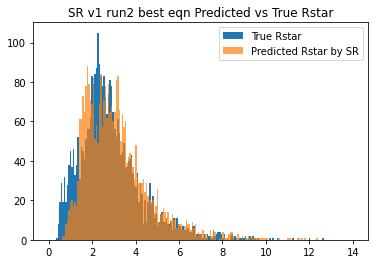

In [25]:
plt.hist(df_raw.SubhaloRstar, bins=200, label='True Rstar'
        , range=(0.0, 14))
plt.hist(sr_disks_v2_eqn1, bins=200, alpha=0.7, label='Predicted Rstar by SR'
        , range=(0.0, 14))
plt.legend(loc='upper right')
plt.title(r'SR v1 run2 best eqn Predicted vs True Rstar')
# plt.savefig('TNG-SIM_images/v28_SR_eqn_search_disks/SR_v1_disks_eqn_search/v1_run2eqnbest_Histogram_SR_pred_true_TNG-SIM_Raw_disks.jpeg', dpi=500)
plt.show()

#### <font color='purple'> <a id =10> </a> <br> Disks Raw 10K iterations

In [36]:
v1_SR_eqns_n_iter10K = pd.read_csv('/Users/festabu/Desktop/ML_galaxy_size_project/Codes/TNG-SIM_images/v28_SR_eqn_search_disks/SR_v1_disks_eqn_search/run3_hall_of_fame_2024-03-27_101250.355.csv', sep='|')

# for i in range(SR_eqns_n_iter1K.shape[0]):
for i in range(20):
    
    print (v1_SR_eqns_n_iter10K.loc[i, 'Equation'])

2.8749177
(SubhaloSFRinRad + 2.007895)
pow(SubhaloMH2 * 6.346493e-8, 0.30265453)
((pow(SubhaloMstar, 0.49023384) * 9.4957875e-7) / SubhaloStarMetallicity)
((pow(SubhaloMstar, 0.78299165) * 1.8389875e-11) / square(SubhaloStarMetallicity))
((pow(SubhaloMstar / SubhaloStarMetallicity, 0.69063383) * 5.567609e-10) / SubhaloStarMetallicity)
(((pow(SubhaloMstar, 0.69719106) * pow(1.9334933e-27, SubhaloStarMetallicity)) / SubhaloStarMetallicity) * 2.3053587e-8)
((((pow(SubhaloMstar, 0.56517166) * pow(-2.1360212e-15, SubhaloStarMetallicity)) * 3.70444e-7) - SubhaloGasMetallicity) / SubhaloStarMetallicity)
((((pow(SubhaloMstar, 0.5743826) * pow(2.7813445e-15 / SubhaloSFRinRad, SubhaloStarMetallicity)) * 3.0276638e-7) - SubhaloGasMetallicity) / SubhaloStarMetallicity)
((((pow(SubhaloMstar, 0.5801295) * pow(-7.534184e-15 / square(SubhaloSFRinRad), SubhaloStarMetallicity)) * 2.643482e-7) - SubhaloGasMetallicity) / SubhaloStarMetallicity)
(((((pow(SubhaloMstar, 0.5768725) * pow(2.5195298e-15, Subhal

In [ ]:
1.8389875e-11*Abs(SubhaloMstar)**0.78299165/SubhaloStarMetallicity**2

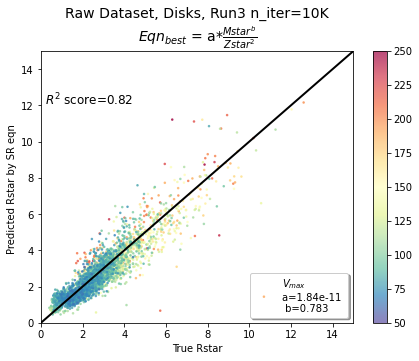

In [48]:
# 'best' eqn is 4th eqn with 10K runs: 1.8389875e-11*Abs(SubhaloMstar)**0.78299165/SubhaloStarMetallicity**2

a=1.84e-11
b=0.783

# Note: This eqn is sensitive to the power of Mstar; rounding up b=0.78 decreases the R2 score by 0.02

sr_disks_v2_eqn1 = a*(df_raw.SubhaloMstar**b)/df_raw.SubhaloStarMetallicity**2

r2_score_disks_1=r2_score(df_raw.SubhaloRstar, sr_disks_v2_eqn1)

fig_complete, ax = plt.subplots(figsize=(7, 5))

fig_SR = ax.scatter(df_raw.SubhaloRstar, sr_disks_v2_eqn1,
            c = df_raw.SubhaloVmax, 
            cmap='Spectral_r',
            s=10, marker='.', alpha=0.7,label= r'$V_{max}$'+'\n'+'a=1.84e-11 \n b=0.783', vmin=50, vmax=250)
ax.text(0.2, 12, r'$R^{2}$ score=' + '{:.2f}'.format(r2_score_disks_1), size=12)
ax.axis([0.0,15, 0.0,15])
ax.plot([0.0, 15], [0.0, 15], color = 'black', linewidth = 2)
ax.set_title(r'Raw Dataset, Disks, Run3 n_iter=10K' + '\n'+ r'$Eqn_{best}$ = a*$\frac{Mstar^{b}}{Zstar^{2}}$', fontsize=14)
ax.set_xlabel('True Rstar')
ax.legend(loc = 'lower right', shadow=True)
ax.set_ylabel('Predicted Rstar by SR eqn ')
fig_complete.colorbar(fig_SR, ax=ax)
# plt.savefig('TNG-SIM_images/v28_SR_eqn_search_disks/SR_v1_disks_eqn_search/v1_run3disks_SR_besteqn_raw.jpeg', dpi=500)
plt.show()

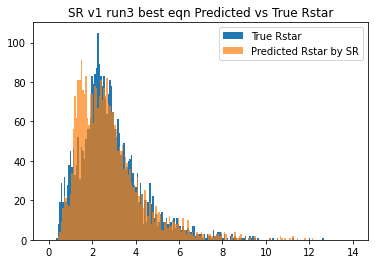

In [50]:
plt.hist(df_raw.SubhaloRstar, bins=200, label='True Rstar'
        , range=(0.0, 14))
plt.hist(sr_disks_v2_eqn1, bins=200, alpha=0.7, label='Predicted Rstar by SR'
        , range=(0.0, 14))
plt.legend(loc='upper right')
plt.title(r'SR v1 run3 best eqn Predicted vs True Rstar')
# plt.savefig('TNG-SIM_images/v28_SR_eqn_search_disks/SR_v1_disks_eqn_search/v1_run3eqnbest_Histogram_SR_pred_true_TNG-SIM_Raw_disks.jpeg', dpi=500)
plt.show()

In [ ]:
((pow(SubhaloMstar / SubhaloStarMetallicity, 0.69063383) * 5.567609e-10) / SubhaloStarMetallicity)


In [ ]:
Mstar

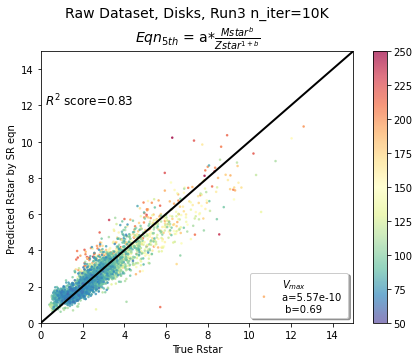

In [8]:
# 5th eqn with 10K runs: ((pow(SubhaloMstar / SubhaloStarMetallicity, 0.69063383) * 5.567609e-10) / SubhaloStarMetallicity)


a=5.57e-10
b=0.69

# Note: This eqn is sensitive to the power of Mstar; rounding up b=0.78 decreases the R2 score by 0.02

sr_disks_v2_eqn1 = a*(df_raw.SubhaloMstar**b)/(df_raw.SubhaloStarMetallicity**(1+b))

r2_score_disks_1=r2_score(df_raw.SubhaloRstar, sr_disks_v2_eqn1)

fig_complete, ax = plt.subplots(figsize=(7, 5))

fig_SR = ax.scatter(df_raw.SubhaloRstar, sr_disks_v2_eqn1,
            c = df_raw.SubhaloVmax, 
            cmap='Spectral_r',
            s=10, marker='.', alpha=0.7,label= r'$V_{max}$'+'\n'+'a=5.57e-10 \n b=0.69', vmin=50, vmax=250)
ax.text(0.2, 12, r'$R^{2}$ score=' + '{:.2f}'.format(r2_score_disks_1), size=12)
ax.axis([0.0,15, 0.0,15])
ax.plot([0.0, 15], [0.0, 15], color = 'black', linewidth = 2)
ax.set_title(r'Raw Dataset, Disks, Run3 n_iter=10K' + '\n'+ r'$Eqn_{5th}$ = a*$\frac{Mstar^{b}}{Zstar^{1+b}}$', fontsize=14)
ax.set_xlabel('True Rstar')
ax.legend(loc = 'lower right', shadow=True)
ax.set_ylabel('Predicted Rstar by SR eqn ')
fig_complete.colorbar(fig_SR, ax=ax)
# plt.savefig('TNG-SIM_images/v28_SR_eqn_search_disks/SR_v1_disks_eqn_search/v1_run3disks_SR_5theqn_raw.jpeg', dpi=500)
plt.show()

### <font color='darkgreen'> <a id =10> </a> <br> Disks 0D+Mvir Dataset Eqn Search
    
Run the following file on terminal:
    SR_TNG-SIM_disks_eqn_search_0D.py

#### <font color='darkgreen'> <a id =10> </a> <br> Disks 0D+Mvir 1K iterations

In [52]:
v1_SR_eqns_n_iter1K = pd.read_csv('/Users/festabu/Desktop/ML_galaxy_size_project/Codes/TNG-SIM_images/v28_SR_eqn_search_disks/SR_v1_disks0D_eqn_search/run1_hall_of_fame_2024-03-28_130934.503.csv', sep='|')

# for i in range(SR_eqns_n_iter1K.shape[0]):
for i in range(18):
    
    print (v1_SR_eqns_n_iter1K.loc[i, 'Equation'])

0.018077785
(SubhaloMH2_hs + 0.015755361)
((SubhaloMstar_hs - SubhaloStarMetallicity) + 0.021118961)
((9.303497e-5 / SubhaloStarMetallicity) + (SubhaloMH2_hs * 3.670404))
((7.3217845e-5 / SubhaloStarMetallicity) + (SubhaloMstar_hs * (0.0151792085 / SubhaloStarMetallicity)))
(((SubhaloMstar_hs * square(0.010806757 / SubhaloStarMetallicity)) + 0.007233258) + SubhaloMH2_hs)
((5.8477293e-5 / SubhaloStarMetallicity) + ((SubhaloMstar_hs + SubhaloMH2_hs) * (0.013062143 / SubhaloStarMetallicity)))
((5.8477293e-5 / SubhaloStarMetallicity) + ((SubhaloMstar_hs + SubhaloMH2_hs) * pow(0.013062143 / SubhaloStarMetallicity, 1.0354933)))
(((6.742056e-5 / SubhaloStarMetallicity) + ((SubhaloMstar_hs + SubhaloMH2_hs) * ((-0.105813414 / SubhaloStarMetallicity) * -0.13601354))) - 0.0023320655)
(((6.742056e-5 / SubhaloStarMetallicity) + ((SubhaloMstar_hs + SubhaloMH2_hs) * (((-0.105813414 / SubhaloStarMetallicity) - SubhaloVmaxRad_hs) * -0.13601354))) - 0.0023320655)
((6.6648405e-5 / SubhaloStarMetallicity)

In [ ]:
(a + b * (c + d/Mvir)/Zstar)*(MH2_hs + Mstar_hs) + e/Zstar

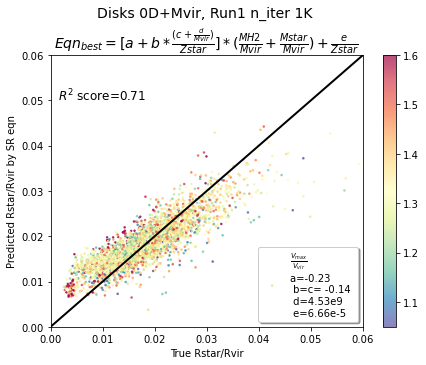

In [70]:
# Rstar/Rvir predicted version
# 'best' eqn is the 11th eqn: (-0.2255647 - 0.13716497*(-0.13716497 + 4528068000.0/Group_M_TopHat200)/SubhaloStarMetallicity)*(SubhaloMH2_hs + SubhaloMstar_hs) + 6.6648405e-5/SubhaloStarMetallicity
a = -0.2255647
b = -0.13716497
c = -0.13716497
d = 4.53e9
e = 6.6648405e-5

sr_disks_v1_eqn1 = (a + b * (c + d/df_0D.Group_M_TopHat200)/df_0D.SubhaloStarMetallicity)*(df_0D.SubhaloMH2_hs + df_0D.SubhaloMstar_hs) + e/df_0D.SubhaloStarMetallicity

r2_score_disks_1=r2_score(df_0D.SubhaloRstar_hs, sr_disks_v1_eqn1)

fig_complete, ax = plt.subplots(figsize=(7, 5))

fig_SR = ax.scatter(df_0D.SubhaloRstar_hs, sr_disks_v1_eqn1,
            c = df_0D.SubhaloVmax_hs, 
            cmap='Spectral_r',
            s=10, marker='.', alpha=0.7, vmin=1.05, vmax=1.60,
            label= r'$\frac{V_{max}}{V_{vir}}$'+'\n'+'a=-0.23 \n b=c= -0.14 \n d=4.53e9 \n e=6.66e-5 ')

ax.text(0.0015, 0.05, r'$R^{2}$ score=' + '{:.2f}'.format(r2_score_disks_1), size=12)
ax.axis([0.0,0.06, 0.0,0.06])
ax.plot([-3.0, 1.0], [-3.0, 1.0], color = 'black', linewidth = 2)
ax.set_title('Disks 0D+Mvir, Run1 n_iter 1K \n'+r'$Eqn_{best}=[a + b * \frac{(c + \frac{d}{Mvir})}{Zstar}]*(\frac{MH2}{Mvir} + \frac{Mstar}{Mvir}) + \frac{e}{Zstar}$', fontsize=14)
ax.set_xlabel('True Rstar/Rvir')
ax.legend(loc = 'lower right', shadow=True)
ax.set_ylabel('Predicted Rstar/Rvir by SR eqn')
fig_complete.colorbar(fig_SR, ax=ax)
# plt.savefig('TNG-SIM_images/v28_SR_eqn_search_disks/SR_v1_disks0D_eqn_search/v1_run1_disks_SR_besteqn_0DwMvir.jpeg', dpi=500)
plt.show()

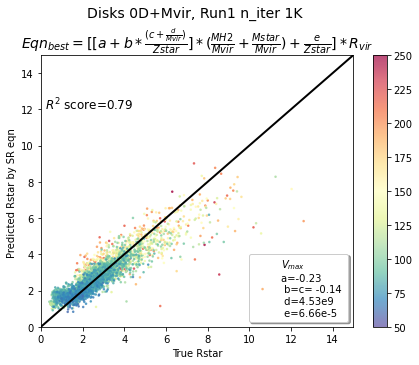

In [18]:
# Rstar predicted version
# 'best' eqn is the 11th eqn: (-0.2255647 - 0.13716497*(-0.13716497 + 4528068000.0/Group_M_TopHat200)/SubhaloStarMetallicity)*(SubhaloMH2_hs + SubhaloMstar_hs) + 6.6648405e-5/SubhaloStarMetallicity
a = -0.2255647
b = -0.13716497
c = -0.13716497
d = 4.53e9
e = 6.6648405e-5

sr_disks_v1_eqn1 = ((a + b * (c + d/df_0D.Group_M_TopHat200)/df_0D.SubhaloStarMetallicity)*(df_0D.SubhaloMH2_hs + df_0D.SubhaloMstar_hs) + e/df_0D.SubhaloStarMetallicity)*df_raw.Group_R_TopHat200


r2_score_disks_1=r2_score(df_raw.SubhaloRstar, sr_disks_v1_eqn1)

fig_complete, ax = plt.subplots(figsize=(7, 5))

fig_SR = ax.scatter(df_raw.SubhaloRstar, sr_disks_v1_eqn1,
            c = df_raw.SubhaloVmax, 
            cmap='Spectral_r',
            s=10, marker='.', alpha=0.7,label= r'$V_{max}$'+'\n'+'a=-0.23 \n b=c= -0.14 \n d=4.53e9 \n e=6.66e-5 ', vmin=50, vmax=250)
ax.text(0.2, 12, r'$R^{2}$ score=' + '{:.2f}'.format(r2_score_disks_1), size=12)
ax.axis([0.0,15, 0.0,15])
ax.plot([0.0, 15], [0.0, 15], color = 'black', linewidth = 2)
ax.set_title('Disks 0D+Mvir, Run1 n_iter 1K \n'+r'$Eqn_{best}=[[a + b * \frac{(c + \frac{d}{Mvir})}{Zstar}]*(\frac{MH2}{Mvir} + \frac{Mstar}{Mvir}) + \frac{e}{Zstar}]*R_{vir}$', fontsize=14)
ax.set_xlabel('True Rstar')
ax.legend(loc = 'lower right', shadow=True)
ax.set_ylabel('Predicted Rstar by SR eqn ')
fig_complete.colorbar(fig_SR, ax=ax)
# plt.savefig('TNG-SIM_images/v28_SR_eqn_search_disks/SR_v1_disks0D_eqn_search/v1_run1_disks_SR_besteqn_0DwMvir_2.jpeg', dpi=500)
plt.show()

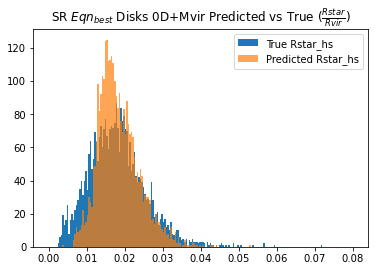

In [56]:
plt.hist(df_0D.SubhaloRstar_hs, bins=200, label='True Rstar_hs'
        , range=(0.0, 0.08))
plt.hist(sr_disks_v1_eqn1, bins=200, alpha=0.7, label='Predicted Rstar_hs'
        , range=(0.0, 0.08))
plt.legend(loc='upper right')
plt.title(r'SR $Eqn_{best}$ Disks 0D+Mvir Predicted vs True $(\frac{Rstar}{Rvir})$')
# plt.savefig('TNG-SIM_images/v28_SR_eqn_search_disks/SR_v1_disks_eqn_search/v1_run1_Histogram_SReqnbest_pred_true_TNG-SIM_0D_DiskswMvir.jpeg', dpi=500)
plt.show()

#### <font color='darkgreen'> <a id =10> </a> <br> Disks 0D+Mvir 5K iterations

In [60]:
v1_SR_eqns_n_iter5K = pd.read_csv('/Users/festabu/Desktop/ML_galaxy_size_project/Codes/TNG-SIM_images/v28_SR_eqn_search_disks/SR_v1_disks0D_eqn_search/run2_hall_of_fame_2024-03-28_151637.204.csv', sep='|')

# for i in range(SR_eqns_n_iter1K.shape[0]):
for i in range(20):
    
    print (v1_SR_eqns_n_iter5K.loc[i, 'Equation'])

0.018077783
(SubhaloMH2_hs + 0.01575536)
((SubhaloMstar_hs - SubhaloStarMetallicity) + 0.021118961)
((0.0151793705 / SubhaloStarMetallicity) * (SubhaloMstar_hs + 0.00482323))
((0.01306215 / SubhaloStarMetallicity) * ((SubhaloMstar_hs + 0.004476835) + SubhaloMH2_hs))
(((0.01557011 / SubhaloStarMetallicity) * (SubhaloMstar_hs + 0.0076481826)) - (7.972136e8 / Group_M_TopHat200))
(((0.013332125 / SubhaloStarMetallicity) * (SubhaloMstar_hs + (SubhaloMH2_hs + 0.007643503))) - (7.546953e8 / Group_M_TopHat200))
(((0.014551461 / SubhaloStarMetallicity) * ((SubhaloMstar_hs + SubhaloMH2_hs) + 0.007851757)) - (52888.574 / pow(Group_M_TopHat200, 0.6099702)))
(((0.014442709 / SubhaloStarMetallicity) * ((SubhaloMstar_hs + SubhaloMH2_hs) + 0.008170959)) - (76750.67 / pow(square(Group_M_TopHat200), 0.311455)))
((((0.01470253 / SubhaloStarMetallicity) - SubhaloMstar_hs) * ((SubhaloMstar_hs + SubhaloMH2_hs) + 0.0076763346)) - (52888.586 / pow(Group_M_TopHat200, 0.6099709)))
((((0.014864078 / SubhaloStarM

In [ ]:
0.0151793705*(SubhaloMstar_hs + 0.00482323)/SubhaloStarMetallicity

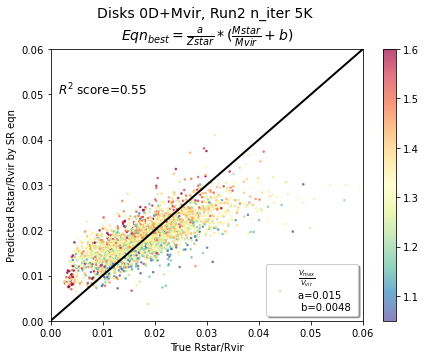

In [76]:
# Rstar/Rvir predicted version
# 'best' eqn w 5K iterations is the 3rd eqn: 0.0151793705*(SubhaloMstar_hs + 0.00482323)/SubhaloStarMetallicity
a = 0.015
b = 0.0048

sr_disks_v1_eqn1 = a *(df_0D.SubhaloMstar_hs + b)/df_0D.SubhaloStarMetallicity
r2_score_disks_1=r2_score(df_0D.SubhaloRstar_hs, sr_disks_v1_eqn1)

fig_complete, ax = plt.subplots(figsize=(7, 5))

fig_SR = ax.scatter(df_0D.SubhaloRstar_hs, sr_disks_v1_eqn1,
            c = df_0D.SubhaloVmax_hs, 
            cmap='Spectral_r',
            s=10, marker='.', alpha=0.7, vmin=1.05, vmax=1.60,
            label= r'$\frac{V_{max}}{V_{vir}}$'+'\n'+'a=0.015 \n b=0.0048 ')

ax.text(0.0015, 0.05, r'$R^{2}$ score=' + '{:.2f}'.format(r2_score_disks_1), size=12)
ax.axis([0.0,0.06, 0.0,0.06])
ax.plot([-3.0, 1.0], [-3.0, 1.0], color = 'black', linewidth = 2)
ax.set_title('Disks 0D+Mvir, Run2 n_iter 5K \n'+r'$Eqn_{best}=\frac{a}{Zstar}*(\frac{Mstar}{Mvir} + b) $', fontsize=14)
ax.set_xlabel('True Rstar/Rvir')
ax.legend(loc = 'lower right', shadow=True)
ax.set_ylabel('Predicted Rstar/Rvir by SR eqn')
fig_complete.colorbar(fig_SR, ax=ax)
# plt.savefig('TNG-SIM_images/v28_SR_eqn_search_disks/SR_v1_disks0D_eqn_search/v1_run2_disks_SR_besteqn_0DwMvir.jpeg', dpi=500)
plt.show()

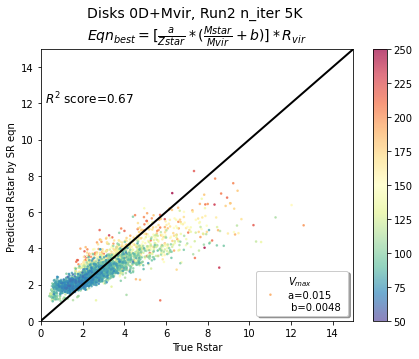

In [16]:
# Rstar predicted version
# 'best' eqn w 5K iterations is the 3rd eqn: 0.0151793705*(SubhaloMstar_hs + 0.00482323)/SubhaloStarMetallicity
a = 0.015
b = 0.0048

sr_disks_v1_eqn1 =( a *(df_0D.SubhaloMstar_hs + b)/df_0D.SubhaloStarMetallicity )*df_raw.Group_R_TopHat200


r2_score_disks_1=r2_score(df_raw.SubhaloRstar, sr_disks_v1_eqn1)

fig_complete, ax = plt.subplots(figsize=(7, 5))

fig_SR = ax.scatter(df_raw.SubhaloRstar, sr_disks_v1_eqn1,
            c = df_raw.SubhaloVmax, 
            cmap='Spectral_r',
            s=10, marker='.', alpha=0.7,label= r'$V_{max}$'+'\n'+'a=0.015 \n b=0.0048 ', vmin=50, vmax=250)
ax.text(0.2, 12, r'$R^{2}$ score=' + '{:.2f}'.format(r2_score_disks_1), size=12)
ax.axis([0.0,15, 0.0,15])
ax.plot([0.0, 15], [0.0, 15], color = 'black', linewidth = 2)
ax.set_title('Disks 0D+Mvir, Run2 n_iter 5K \n'+r'$Eqn_{best}=[\frac{a}{Zstar}*(\frac{Mstar}{Mvir} + b)]*R_{vir} $', fontsize=14)
ax.set_xlabel('True Rstar')
ax.legend(loc = 'lower right', shadow=True)
ax.set_ylabel('Predicted Rstar by SR eqn ')
fig_complete.colorbar(fig_SR, ax=ax)
# plt.savefig('TNG-SIM_images/v28_SR_eqn_search_disks/SR_v1_disks0D_eqn_search/v1_run2_disks_SR_besteqn_0DwMvir_2.jpeg', dpi=500)
plt.show()

In [ ]:
(((0.01557011 / SubhaloStarMetallicity) * (SubhaloMstar_hs + 0.0076481826)) - (7.972136e8 / Group_M_TopHat200))

In [ ]:
(((a / SubhaloStarMetallicity) * (SubhaloMstar_hs + b)) - (c / Group_M_TopHat200))

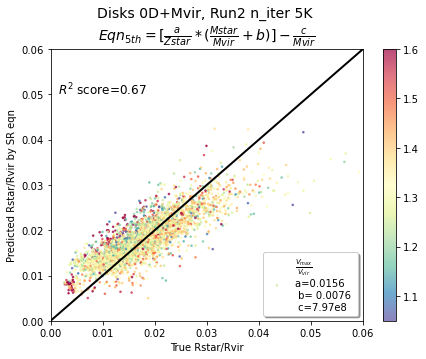

In [81]:
# Rstar/Rvir predicted version
# 5th eqn w 5K iterations: (((0.01557011 / SubhaloStarMetallicity) * (SubhaloMstar_hs + 0.0076481826)) - (7.972136e8 / Group_M_TopHat200))
a = 0.0156
b = 0.0076
c = 7.97e8

sr_disks_v1_eqn1 = ((a/df_0D.SubhaloStarMetallicity) *(df_0D.SubhaloMstar_hs + b)) - (c / df_0D.Group_M_TopHat200)

r2_score_disks_1=r2_score(df_0D.SubhaloRstar_hs, sr_disks_v1_eqn1)

fig_complete, ax = plt.subplots(figsize=(7, 5))

fig_SR = ax.scatter(df_0D.SubhaloRstar_hs, sr_disks_v1_eqn1,
            c = df_0D.SubhaloVmax_hs, 
            cmap='Spectral_r',
            s=10, marker='.', alpha=0.7, vmin=1.05, vmax=1.60,
            label= r'$\frac{V_{max}}{V_{vir}}$'+'\n'+'a=0.0156 \n b= 0.0076 \n c=7.97e8')

ax.text(0.0015, 0.05, r'$R^{2}$ score=' + '{:.2f}'.format(r2_score_disks_1), size=12)
ax.axis([0.0,0.06, 0.0,0.06])
ax.plot([-3.0, 1.0], [-3.0, 1.0], color = 'black', linewidth = 2)
ax.set_title('Disks 0D+Mvir, Run2 n_iter 5K \n'+r'$Eqn_{5th}=[\frac{a}{Zstar}*(\frac{Mstar}{Mvir} + b)] - \frac{c}{Mvir} $', fontsize=14)
ax.set_xlabel('True Rstar/Rvir')
ax.legend(loc = 'lower right', shadow=True)
ax.set_ylabel('Predicted Rstar/Rvir by SR eqn')
fig_complete.colorbar(fig_SR, ax=ax)
# plt.savefig('TNG-SIM_images/v28_SR_eqn_search_disks/SR_v1_disks0D_eqn_search/v1_run2_disks_SR_5theqn_0DwMvir.jpeg', dpi=500)
plt.show()

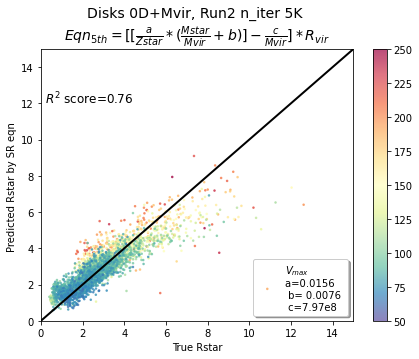

In [15]:
# Rstar predicted version
# 5th eqn w 5K iterations: (((0.01557011 / SubhaloStarMetallicity) * (SubhaloMstar_hs + 0.0076481826)) - (7.972136e8 / Group_M_TopHat200))
a = 0.0156
b = 0.0076
c = 7.97e8

sr_disks_v1_eqn1 = (((a/df_0D.SubhaloStarMetallicity) *(df_0D.SubhaloMstar_hs + b)) - (c / df_0D.Group_M_TopHat200))*df_raw.Group_R_TopHat200


r2_score_disks_1=r2_score(df_raw.SubhaloRstar, sr_disks_v1_eqn1)

fig_complete, ax = plt.subplots(figsize=(7, 5))

fig_SR = ax.scatter(df_raw.SubhaloRstar, sr_disks_v1_eqn1,
            c = df_raw.SubhaloVmax, 
            cmap='Spectral_r',
            s=10, marker='.', alpha=0.7,label= r'$V_{max}$'+'\n'+'a=0.0156 \n b= 0.0076 \n c=7.97e8', vmin=50, vmax=250)
ax.text(0.2, 12, r'$R^{2}$ score=' + '{:.2f}'.format(r2_score_disks_1), size=12)
ax.axis([0.0,15, 0.0,15])
ax.plot([0.0, 15], [0.0, 15], color = 'black', linewidth = 2)
ax.set_title('Disks 0D+Mvir, Run2 n_iter 5K \n'+r'$Eqn_{5th}=[[\frac{a}{Zstar}*(\frac{Mstar}{Mvir} + b)] - \frac{c}{Mvir}]*R_{vir} $', fontsize=14)
ax.set_xlabel('True Rstar')
ax.legend(loc = 'lower right', shadow=True)
ax.set_ylabel('Predicted Rstar by SR eqn ')
fig_complete.colorbar(fig_SR, ax=ax)
# plt.savefig('TNG-SIM_images/v28_SR_eqn_search_disks/SR_v1_disks0D_eqn_search/v1_run2_disks_SR_5theqn_0DwMvir_2.jpeg', dpi=500)
plt.show()

#### <font color='darkgreen'> <a id =10> </a> <br> Disks 0D+Mvir 10K iterations

In [85]:
v1_SR_eqns_n_iter10K = pd.read_csv('/Users/festabu/Desktop/ML_galaxy_size_project/Codes/TNG-SIM_images/v28_SR_eqn_search_disks/SR_v1_disks0D_eqn_search/run3_hall_of_fame_2024-03-28_181302.030.csv', sep='|')

# for i in range(SR_eqns_n_iter1K.shape[0]):
for i in range(18):
    
    print (v1_SR_eqns_n_iter10K.loc[i, 'Equation'])

0.018077783
(SubhaloMH2_hs + 0.015755361)
((SubhaloMstar_hs + 0.021118961) - SubhaloStarMetallicity)
((SubhaloMstar_hs + 0.0048236297) * (0.0151791 / SubhaloStarMetallicity))
(((SubhaloMstar_hs + 0.0044763964) + SubhaloMH2_hs) * (0.013062479 / SubhaloStarMetallicity))
(SubhaloMstar_hs * ((4.7728996e-8 / square(SubhaloStarMetallicity)) * pow(Group_M_TopHat200, 0.32972956)))
((SubhaloMstar_hs * square((-0.00020663084 / SubhaloStarMetallicity) * pow(Group_M_TopHat200, 0.16433553))) - -0.00272832)
((SubhaloMstar_hs + 0.002614693) * (((0.000210547 / SubhaloStarMetallicity) * pow(Group_M_TopHat200, 0.1930352)) - 1.2295855))
(((SubhaloMstar_hs + 0.0031562874) + SubhaloMH2_hs) * (((0.0001492794 / SubhaloStarMetallicity) * pow(Group_M_TopHat200, 0.19232537)) - 0.73317385))
(((SubhaloMstar_hs + (SubhaloMH2_hs + 0.0026041355)) * (((0.00016210206 / SubhaloStarMetallicity) * pow(Group_M_TopHat200, 0.19394667)) - 0.7665415)) - SubhaloMH2_hs)
(((SubhaloMstar_hs + (SubhaloMH2_hs + 0.0024840017)) * (((

In [ ]:
4.7728996e-8*SubhaloMstar_hs*Abs(Group_M_TopHat200)**0.32972956/SubhaloStarMetallicity**2

a*SubhaloMstar_hs*Abs(Group_M_TopHat200)**b/SubhaloStarMetallicity**2

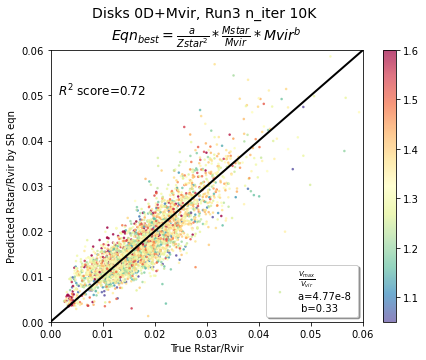

In [91]:
# Rstar/Rvir predicted version
# 'best' eqn w 10K iterations is the 5th eqn: 4.7728996e-8*SubhaloMstar_hs*Abs(Group_M_TopHat200)**0.32972956/SubhaloStarMetallicity**2
a = 4.77e-8
b = 0.33

sr_disks_v1_eqn1 = (a/df_0D.SubhaloStarMetallicity**2) * df_0D.SubhaloMstar_hs*(df_0D.Group_M_TopHat200**b)
r2_score_disks_1=r2_score(df_0D.SubhaloRstar_hs, sr_disks_v1_eqn1)

fig_complete, ax = plt.subplots(figsize=(7, 5))

fig_SR = ax.scatter(df_0D.SubhaloRstar_hs, sr_disks_v1_eqn1,
            c = df_0D.SubhaloVmax_hs, 
            cmap='Spectral_r',
            s=10, marker='.', alpha=0.7, vmin=1.05, vmax=1.60,
            label= r'$\frac{V_{max}}{V_{vir}}$'+'\n'+'a=4.77e-8 \n b=0.33 ')

ax.text(0.0015, 0.05, r'$R^{2}$ score=' + '{:.2f}'.format(r2_score_disks_1), size=12)
ax.axis([0.0,0.06, 0.0,0.06])
ax.plot([-3.0, 1.0], [-3.0, 1.0], color = 'black', linewidth = 2)
ax.set_title('Disks 0D+Mvir, Run3 n_iter 10K \n'+r'$Eqn_{best}=\frac{a}{Zstar^{2}}* \frac{Mstar}{Mvir}  * Mvir^{b} $', fontsize=14)
ax.set_xlabel('True Rstar/Rvir')
ax.legend(loc = 'lower right', shadow=True)
ax.set_ylabel('Predicted Rstar/Rvir by SR eqn')
fig_complete.colorbar(fig_SR, ax=ax)
# plt.savefig('TNG-SIM_images/v28_SR_eqn_search_disks/SR_v1_disks0D_eqn_search/v1_run3_disks_SR_besteqn_0DwMvir.jpeg', dpi=500)
plt.show()

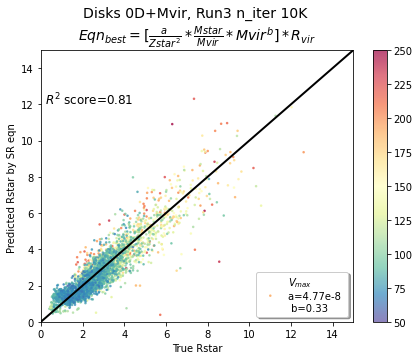

In [19]:
# Rstar predicted version
# 'best' eqn w 10K iterations is the 5th eqn: 4.7728996e-8*SubhaloMstar_hs*Abs(Group_M_TopHat200)**0.32972956/SubhaloStarMetallicity**2
a = 4.77e-8
b = 0.33

sr_disks_v1_eqn1 = ((a/df_0D.SubhaloStarMetallicity**2) * df_0D.SubhaloMstar_hs*(df_0D.Group_M_TopHat200**b))*df_raw.Group_R_TopHat200


r2_score_disks_1=r2_score(df_raw.SubhaloRstar, sr_disks_v1_eqn1)

fig_complete, ax = plt.subplots(figsize=(7, 5))

fig_SR = ax.scatter(df_raw.SubhaloRstar, sr_disks_v1_eqn1,
            c = df_raw.SubhaloVmax, 
            cmap='Spectral_r',
            s=10, marker='.', alpha=0.7,label= r'$V_{max}$'+'\n'+'a=4.77e-8 \n b=0.33 ', vmin=50, vmax=250)
ax.text(0.2, 12, r'$R^{2}$ score=' + '{:.2f}'.format(r2_score_disks_1), size=12)
ax.axis([0.0,15, 0.0,15])
ax.plot([0.0, 15], [0.0, 15], color = 'black', linewidth = 2)
ax.set_title('Disks 0D+Mvir, Run3 n_iter 10K \n'+r'$Eqn_{best}=[\frac{a}{Zstar^{2}}* \frac{Mstar}{Mvir}  * Mvir^{b}]*R_{vir} $', fontsize=14)
ax.set_xlabel('True Rstar')
ax.legend(loc = 'lower right', shadow=True)
ax.set_ylabel('Predicted Rstar by SR eqn ')
fig_complete.colorbar(fig_SR, ax=ax)
# plt.savefig('TNG-SIM_images/v28_SR_eqn_search_disks/SR_v1_disks0D_eqn_search/v1_run3_disks_SR_besteqn_0DwMvir_2.jpeg', dpi=500)
plt.show()

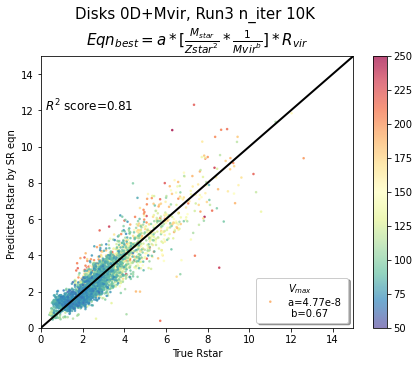

In [30]:
# Same eqn as in previous line, simplifed Mvir powers sin Mstar_hs contains Mvir
# Rstar predicted version
# 'best' eqn w 10K iterations is the 5th eqn: 4.7728996e-8*SubhaloMstar_hs*Abs(Group_M_TopHat200)**0.32972956/SubhaloStarMetallicity**2
a = 4.77e-8
b = 0.67

sr_disks_v1_eqn1 = a*((df_raw.SubhaloMstar/df_0D.SubhaloStarMetallicity**2) *(1/df_0D.Group_M_TopHat200**b))*df_raw.Group_R_TopHat200


r2_score_disks_1=r2_score(df_raw.SubhaloRstar, sr_disks_v1_eqn1)

fig_complete, ax = plt.subplots(figsize=(7, 5))

fig_SR = ax.scatter(df_raw.SubhaloRstar, sr_disks_v1_eqn1,
            c = df_raw.SubhaloVmax, 
            cmap='Spectral_r',
            s=10, marker='.', alpha=0.7,label= r'$V_{max}$'+'\n'+'a=4.77e-8 \n b=0.67 ', vmin=50, vmax=250)
ax.text(0.2, 12, r'$R^{2}$ score=' + '{:.2f}'.format(r2_score_disks_1), size=12)
ax.axis([0.0,15, 0.0,15])
ax.plot([0.0, 15], [0.0, 15], color = 'black', linewidth = 2)
ax.set_title('Disks 0D+Mvir, Run3 n_iter 10K \n'+r'$Eqn_{best}=a*[\frac{M_{star}}{Zstar^{2}}* \frac{1}{Mvir^{b}}]*R_{vir} $', fontsize=15)
ax.set_xlabel('True Rstar')
ax.legend(loc = 'lower right', shadow=True)
ax.set_ylabel('Predicted Rstar by SR eqn ')
fig_complete.colorbar(fig_SR, ax=ax)
# plt.savefig('TNG-SIM_images/v28_SR_eqn_search_disks/SR_v1_disks0D_eqn_search/v1_run3_disks_SR_besteqn_0DwMvir_2_newstyle.jpeg', dpi=500)
plt.show()